<a href="https://colab.research.google.com/github/thanhlamnguyen/ANOVA/blob/main/Z_test_math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scipy==1.6.3

     |████████████████████████████████| 27.4MB 140kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats, interpolate
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 18})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Tính giá trị tới hạn bằng scipy và hàm ppf (hàm ngược của hàm cdf) #
from scipy.stats import norm
def critical_value(alpha, tail=0):
    '''Tính giá trị tới hạn: tail=0:: 2phia; tail=-1:left; tail=1:right'''
    if tail == -1: return norm.ppf(alpha)
    elif tail == 1: return norm.ppf(1-alpha)
    else: return (norm.ppf(alpha/2), norm.ppf(1-alpha/2))

alpha = 0.05
# tu bang A.2 chon t_* = 1.96
# dung ham cdf de tinh gia tri p chinh xac neu t_*=1.96
print(f"Giá trị tới hạn 2 phía: {critical_value(alpha)}")
print(f"Giá trị tới hạn 1 phía (trái): {critical_value(alpha, tail=-1)}")
print(f"Giá trị tới hạn 1 phía (phải): {critical_value(alpha, tail=1)}")
# Khi thi ta chấp nhận t_* = 1.96
# Trong khi thực hành thì ta không chấp nhận t_*=1.96 mà giá trị thực là t_* = 1.959963984540054

Giá trị tới hạn 2 phía: (-1.9599639845400545, 1.959963984540054)
Giá trị tới hạn 1 phía (trái): -1.6448536269514729
Giá trị tới hạn 1 phía (phải): 1.6448536269514722


In [ ]:
gia_nha_dat_us = pd.read_csv("gia_nha_dat_us.csv")
gia_nha_dat_us.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df = gia_nha_dat_us[['MSSubClass', 'MSZoning', 'LotArea', 'SalePrice']]
df.head()

,MSSubClass,MSZoning,LotArea,SalePrice
0,60,RL,8450,208500
1,20,RL,9600,181500
2,60,RL,11250,223500
3,70,RL,9550,140000
4,60,RL,14260,250000


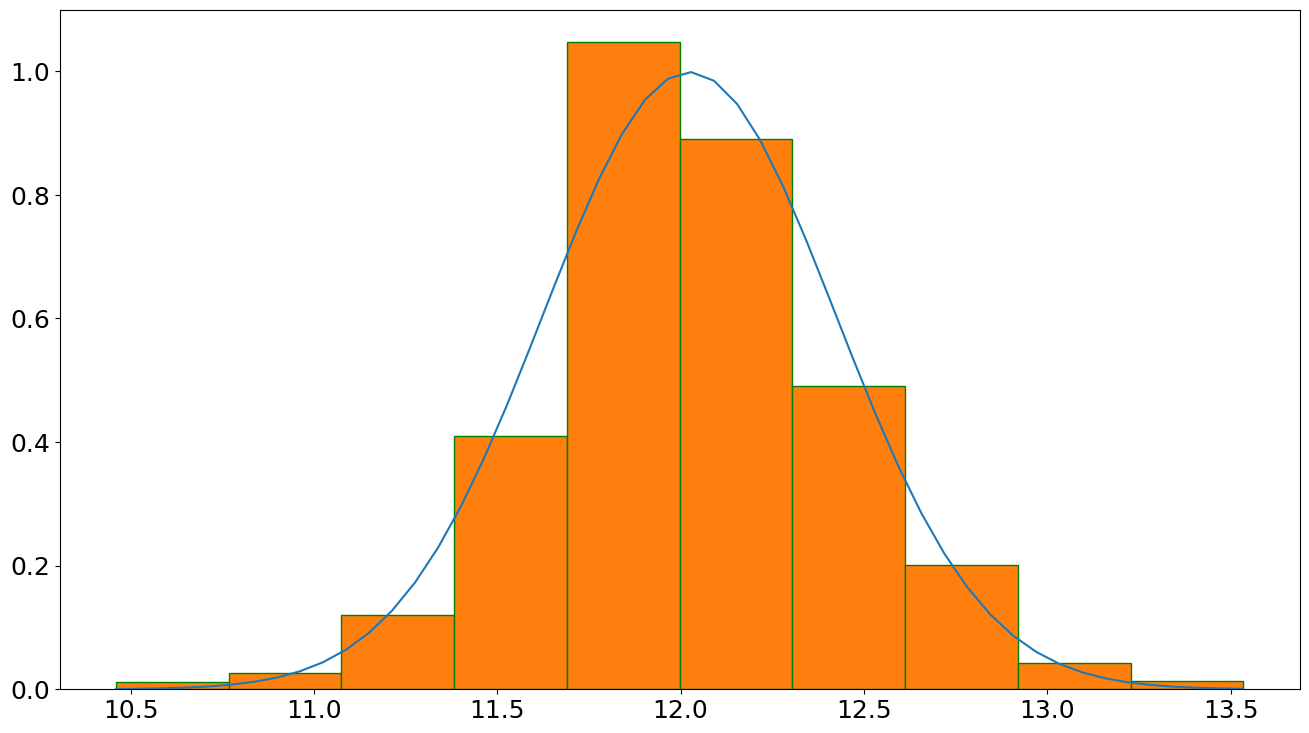

In [ ]:
# Engineering feature: log transform #
data = df['SalePrice']
# Sử dụng ln(1+r) ~ r để tránh rate of change #
data = np.log1p(data)

# Kiem tra data co chuan hay khong?
mean = np.mean(data)
# ddof=1 :: hiệu chỉnh
std = np.std(data, ddof=1)
domain = np.linspace(np.min(data), np.max(data))
plt.plot(domain, stats.norm.pdf(domain, mean, std))
#density=True :: chuẩn hóa dữ liệu về normal
plt.hist(data, edgecolor='green', density=True)
plt.show()

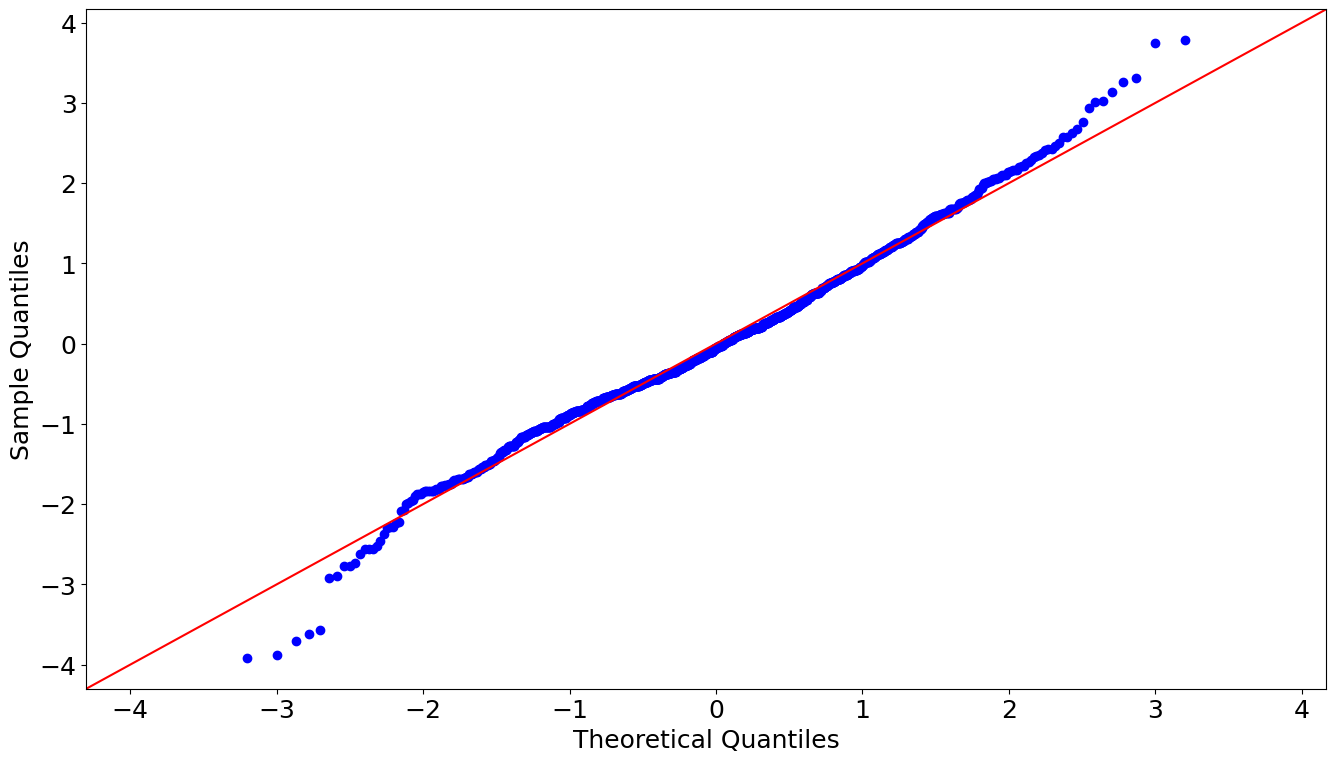

In [ ]:
def standadize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean)/std

sm.qqplot(standadize(data), line ='45')
plt.show()

In [ ]:
my_mean = 150000
my_log_mean = np.log1p(my_mean)
print(my_log_mean)

11.918397239722838


In [ ]:
def results(p, vals=['mean1', 'mean2'], alpha=0.05):
    cols=['score', 'p_value', 'KetLuan']
    if p['p_value'] < alpha:
           p['KetLuan'] = f"Chấp nhận H1 với mức ý nghĩa {alpha}"
    if p['p_value'] >= alpha:
           p['KetLuan'] = f"Chấp nhận H0 với mức ý nghĩa {alpha}"
    df = pd.DataFrame(p, index=[''])
    if vals: cols = vals + cols
    return df[cols]

In [ ]:
# Lay ngau nhien 100 diem du lieu #
sample_1 = data.sample(n=100)

In [ ]:
#Kiem dinh mean cua sample so voi ky vong mu_0=11.918397239722838
# kiem dinh 2 phia: H0: mu = mu_0, H1: mu != mu_0
from scipy.stats import ttest_1samp
p = {}
p['mean1'] = np.mean(sample_1)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample_1, my_log_mean)
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.028675,11.918397,2.829806,0.00564,Chấp nhận H1 với mức ý nghĩa 0.05


In [ ]:
# alternative{‘two-sided’, ‘less’, ‘greater’}
# kiem dinh ben trai: H0 mu = mu_0, H1: mu < mu_0
p = {}
p['mean1'] = np.mean(sample_1)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample_1, my_log_mean, alternative='less')
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.028675,11.918397,2.829806,0.99718,Chấp nhận H0 với mức ý nghĩa 0.05


In [ ]:
# alternative{‘two-sided’, ‘less’, ‘greater’}
# kiem dinh ben phai: H0 mu = mu_0, H1: mu > mu_0
p = {}
p['mean1'] = np.mean(sample_1)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample_1, my_log_mean, alternative='greater')
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.028675,11.918397,2.829806,0.00282,Chấp nhận H1 với mức ý nghĩa 0.05


**Chọn giá trị n lớn hơn 100 khác nhau**

In [ ]:
so_luong = np.linspace(200, 1400, 7)
sample_s = []
for n in (so_luong):
    n = int(n)
    sample_s.append(data.sample(n=n))

In [ ]:
print(sample_s[1])

478     12.601491
1269    11.877576
227     11.571204
1018    11.982935
403     12.460719
          ...    
866     12.424811
119     12.007567
465     12.093693
280     12.339296
371     11.808821
Name: SalePrice, Length: 400, dtype: float64


**Kiểm định 2 phía**: khi mẫu càng lớn thì p_value càng dần tiến đến 1. Kết luận dần tiến về phía chấp nhận H0

In [ ]:
for sample in sample_s:
    p = {}
    p['mean1'] = np.mean(sample)
    p['mean2'] = my_log_mean
    p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean, alternative='less')
    print(f' kết quả khi n = {len(sample)}')
    print(results(p))


 kết quả khi n = 200
      mean1      mean2     score   p_value                            KetLuan
  12.019629  11.918397  3.691164  0.999856  Chấp nhận H0 với mức ý nghĩa 0.05
 kết quả khi n = 400
      mean1      mean2     score  p_value                            KetLuan
  12.043054  11.918397  6.168602      1.0  Chấp nhận H0 với mức ý nghĩa 0.05
 kết quả khi n = 600
      mean1      mean2     score  p_value                            KetLuan
  12.039452  11.918397  7.445314      1.0  Chấp nhận H0 với mức ý nghĩa 0.05
 kết quả khi n = 800
      mean1      mean2     score  p_value                            KetLuan
  12.007105  11.918397  6.352496      1.0  Chấp nhận H0 với mức ý nghĩa 0.05
 kết quả khi n = 1000
      mean1      mean2     score  p_value                            KetLuan
  12.025072  11.918397  8.513889      1.0  Chấp nhận H0 với mức ý nghĩa 0.05
 kết quả khi n = 1200
      mean1      mean2     score  p_value                            KetLuan
  12.019921  11.918397 

**Kiểm định một phía trái**: khi mẫu càng lớn thì p_value càng dần tiến đến 1. Kết luận dần tiến về phía chấp nhận H0

In [ ]:
for sample in sample_s:
    p = {}
    p['mean1'] = np.mean(sample)
    p['mean2'] = my_log_mean
    p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean)
    print(f' kết quả khi n = {len(sample)}')
    print(results(p))
    print(' ')

 kết quả khi n = 200
      mean1      mean2     score   p_value                            KetLuan
  12.019629  11.918397  3.691164  0.000288  Chấp nhận H1 với mức ý nghĩa 0.05
 
 kết quả khi n = 400
      mean1      mean2  ...       p_value                            KetLuan
  12.043054  11.918397  ...  1.691872e-09  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 600
      mean1      mean2  ...       p_value                            KetLuan
  12.039452  11.918397  ...  3.383588e-13  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 800
      mean1      mean2  ...       p_value                            KetLuan
  12.007105  11.918397  ...  3.554009e-10  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 1000
      mean1      mean2  ...       p_value                            KetLuan
  12.025072  11.918397  ...  6.106186e-17  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 1200
  

**Kiểm định một phía phải**: khi mẫu càng lớn thì p_value càng dần tiến về 0. Kết luận dần tiến về phía chấp nhận H1

In [ ]:
for sample in sample_s:
    p = {}
    p['mean1'] = np.mean(sample)
    p['mean2'] = my_log_mean
    p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean, alternative='greater')
    print(f' kết quả khi n = {len(sample)}')
    print(results(p))
    print(' ')

 kết quả khi n = 200
      mean1      mean2     score   p_value                            KetLuan
  12.019629  11.918397  3.691164  0.000144  Chấp nhận H1 với mức ý nghĩa 0.05
 
 kết quả khi n = 400
      mean1      mean2  ...       p_value                            KetLuan
  12.043054  11.918397  ...  8.459362e-10  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 600
      mean1      mean2  ...       p_value                            KetLuan
  12.039452  11.918397  ...  1.691794e-13  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 800
      mean1      mean2  ...       p_value                            KetLuan
  12.007105  11.918397  ...  1.777004e-10  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 1000
      mean1      mean2  ...       p_value                            KetLuan
  12.025072  11.918397  ...  3.053093e-17  Chấp nhận H1 với mức ý nghĩa 0.05

[1 rows x 5 columns]
 
 kết quả khi n = 1200
  

Nhận thấy để tìm ra được giá trị kỳ vọng **gần với giá trị trung bình của mẫu nhất** (*với mức ý nghĩa 0.05*). Thì giá trị kì vọng đó nên **bằng đúng với trung bình mẫu**.

In [ ]:
my_log_mean_2 = 12.024474
# suy ra my_mean
my_mean_2 =  np.expm1(my_log_mean_2)
print(my_mean_2)

166786.19543785087


In [ ]:
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean_2
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean_2)
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.025243,12.024474,0.072107,0.942527,Chấp nhận H0 với mức ý nghĩa 0.05
